In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as sgr
from analysis_tools import plot_trend

In [36]:
data = pd.read_csv("results-22-Mar-2018.csv", index_col=0)
data['host'] = 'rapi'
more_data = pd.read_csv("outputMac5.csv", index_col=0)
more_data['host'] = 'laptop'
data = pd.concat([data, more_data])
data.groupby(['host','pi_count','file_count'])['time'].describe()

count         mean         std          min  \
host   pi_count file_count                                                
laptop 1        5             6.0    44.912852    1.535765    43.497887   
rapi   1        4             9.0   659.583791   90.455826   571.922371   
                5             3.0   944.743670   34.171149   905.293288   
                6             6.0  1311.672881  160.420725  1120.226733   
                7             6.0  1654.002264   39.515901  1593.753183   
                8             3.0  1815.821291   33.111660  1783.347645   
                9             3.0  2198.299941   26.988039  2167.138794   
                10            3.0  2333.354026   28.280190  2300.751529   
                11            6.0  2620.984516   10.663404  2603.712789   
                12            3.0  2816.000714   69.149152  2751.480127   
                13            3.0  2983.867707   36.950749  2941.600748   
                14            3.0  3202.183000   26.324595  3172.224688   
                15            3.0  3305.163156   18.439651  3291.485921   
                16            3.0  3435.568818   27.145413  3404.655594   
                17            3.0  3521.032297   47.750737  3471.018914   
                18            3.0  3347.096688   72.471962  3264.190222   
       2        4             9.0   350.099201   43.942788   306.521045   
                5             3.0   622.055557   54.204855   590.249492   
                6             6.0   753.548556   85.225364   668.626463   
                7             6.0   869.106353   32.061560   834.652300   
                8             3.0  1069.662024   17.838246  1054.410425   
                9             3.0  1203.773132   32.873840  1166.208477   
                10            3.0  1182.327506   17.210324  1167.806000   
                11            6.0  1372.469308    3.174396  1369.182427   
                12            3.0  1575.237110   21.938599  1551.962255   
                13            3.0  1599.916018   18.550725  1581.182215   
                14            3.0  1728.550684   34.613478  1693.437116   
                15            3.0  1799.632074   29.707624  1765.961300   
                16            3.0  1856.620831   14.158935  1841.622261   
                17            3.0  1842.228350   36.590115  1801.349135   
...                           ...          ...         ...          ...   
       5        10            3.0   577.203486    2.128888   575.483017   
                11            9.0   636.363615    9.398902   619.940675   
                12            6.0   819.174567   10.216621   807.326476   
                13            6.0   810.158537   13.489887   799.446528   
                14            6.0   886.934898   11.142607   873.393814   
                15            6.0   993.615750   25.634944   964.590795   
                16            6.0   742.974334   18.365770   718.166123   
                17            6.0  1090.352079   80.030652  1013.308571   
                18            6.0  1010.993004   82.792145   913.130440   
                19            3.0  1000.040127   12.975098   988.906260   
                20            3.0  1059.216908   20.248897  1047.066076   
                21            3.0  1009.756988   33.652773   974.413979   
       6        4             3.0   187.595489    2.038153   186.274544   
                5             3.0   156.629490    5.963537   151.103636   
                6             3.0   473.563206   12.336684   461.310248   
                7             3.0   472.989413    5.306290   468.000530   
                8             3.0   334.454632    6.557057   328.305082   
                9             3.0   344.563167    6.258121   337.406813   
                10            3.0   844.644055  547.457934   527.660123   
                11            5.0   600.544534   21.254397   578.064638   
                12            3.0   656.343975   36.1

In [23]:
mod = smf.ols(formula='time ~ np.power(pi_count-2, 3):host', data=data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     33.91
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           2.50e-14
Time:                        07:38:54   Log-Likelihood:                -3185.6
No. Observations:                 402   AIC:                             6377.
Df Residuals:                     399   BIC:                             6389.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               1197.9352     42.275     28.337      0.000    1114.826    1281.045
np.power(pi_count - 2, 3):host[laptop]  1153.0224    277.266      4.159      0.000     607.937    1698.108
np.power(pi_count - 2, 3):host[rapi]     -11.4373      1.533     -7.461      0.000     -14.451      -8.424
==============================================================================
Omnibus:                      114.103   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.544
Skew:                           1.466   Prob(JB):                     2.39e-55
Kurtosis:                       5.534   Cond. No.                         227.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

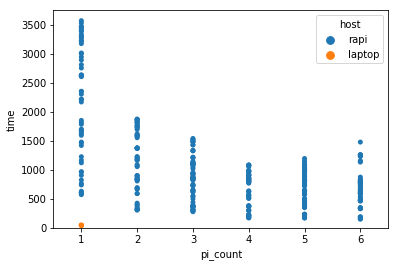

In [24]:
fig, ax = plt.subplots()
sns.stripplot(x='pi_count', y='time', hue='host', data=data, ax=ax)
ax.set_ylim(bottom=0)
#plot_trend(res, 'pi_count', ax)
fig.savefig("pi_count_v_time.png")

In [25]:
laptop_time = data.loc[data['host'] == 'laptop']['time'].mean()
res.params
def pi_count_from_time(time):
    return ((time-res.params['Intercept'])/res.params['np.power(pi_count - 2, 3):host[rapi]'])**(1/3)
pi_count_from_time(laptop_time)

4.6541212273263

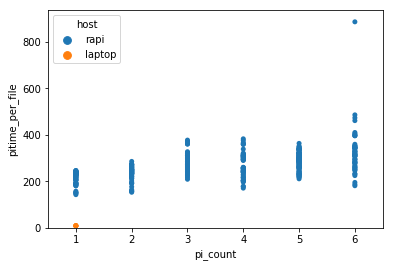

In [37]:
fig, ax = plt.subplots()
data['pitime_per_file'] = data['time']*data['pi_count']/data['file_count']
sns.stripplot(x='pi_count', y='pitime_per_file', hue='host', data=data, ax=ax)
ax.set_ylim(bottom=0)
fig.savefig("pitime_per_file_vs_count.png")

In [27]:
onejump = data['pi_count'].apply(lambda x: x in [1,2,5])

In [28]:
data.loc[onejump]['pitime_per_file'].mean()

246.39044238025673

In [29]:
curve_up = data['pi_count'].apply(lambda x: x in [2,3,4])
count_mod = smf.ols(formula='pitime_per_file ~ pi_count', data=data.loc[curve_up])
count_res = count_mod.fit()
count_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        pitime_per_file   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     17.63
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           4.17e-05
Time:                        07:39:24   Log-Likelihood:                -978.36
No. Observations:                 187   AIC:                             1961.
Df Residuals:                     185   BIC:                             1967.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    211.7436     12.977     16.316      0.000     186.141     237.346
pi_count      17.5231      4.174      4.199      0.000       9.289      25.757
==============================================================================
Omnibus:                        0.300   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.861   Jarque-Bera (JB):                0.117
Skew:                           0.045   Prob(JB):                        0.943
Kurtosis:                       3.082   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

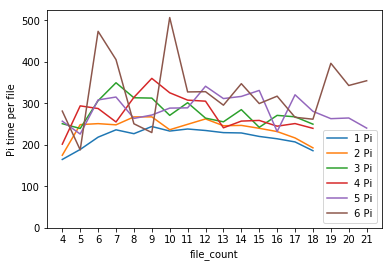

In [38]:
fig, ax = plt.subplots()
# sns.stripplot(x='file_count', y='Ws', hue='pi_count', data=data.loc[data['host'] == 'rapi'], ax=ax)
# ax.plot([33], res.predict({'pi_count': [33],'host': 'rapi'}), 'yo')
pidata = data.loc[data['host'] == 'rapi']
for count, grp in pidata.groupby('pi_count'):
    grp = grp.groupby('file_count').mean()
    line, = ax.plot(grp.index, grp['pitime_per_file'], '-')
    line.set_label(str(count) + " Pi")
ax.set_xlabel("file_count")
ax.set_ylabel("Pi time per file")
ax.set_xticks(pidata['file_count'].unique())
ax.legend()
#ax.autoscale()
#plot_trend(res, 'pi_count', ax)
ax.set_ylim(bottom=0)
fig.savefig('pi_count_vs_Ws.png')